In [1]:
%matplotlib notebook
import time
import numpy as np
import matplotlib
import matplotlib.animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# http://ruder.io/optimizing-gradient-descent/

Gradient Descent for Linear Regression
======

This is meant to show you how gradient descent works and familiarize yourself with the terms and ideas. We're going to look at that least squares.

* The hope is to give you a mechanical view of what we've done in lecture.
* Visualizing these concepts makes life much easier.
* Get into the habit of trying things out! Machine learning is wonderful because it is so successful.

Some boiler plate code.
---
* Just contains the loss
* And some code to make pretty pictures below.

In [2]:
# Refactor for least squares, and then we can visualize.
def least_sq_loss(X, theta_0, theta_1, y, delta=0.1):
    Z = np.zeros( (theta_0.shape[0], theta_1.shape[0]) )
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            u  = np.matrix( [theta_0[i],theta_1[j]] ).T
            v  = X@u - y
            Z[i,j] = np.float(np.dot(v.T,v))
    return 0.5*Z

In [3]:
def render_points(X, y, points, delta=0.2, isocline=False, loss=least_sq_loss):
    (theta_0,theta_1)   = (np.arange(-5,5,delta), np.arange(-5,5,delta))
    J   = loss(X, theta_0, theta_1, y, delta=delta)
    T0,T1 = np.meshgrid(theta_0,theta_1) 
    
    if isocline:
         fig, ax = plt.subplots()
         ax.set_title('Gradient Descent')
         CS = ax.contour(T0, T1, J) 
    else:
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        ax.set_title('Gradient Descent')
        CS = ax.contour3D(T0, T1, J, 50)

    ax.clabel(CS, inline=1, fontsize=10)   
    def animate(i): ax.plot( points[i][0], points[i][1], "or")    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(points), repeat=False)
    return ani

Generate some datapoints.
---

Let's look at some really simply synthetic data. This is a very common model to understand how optimization algorithsm behave. I'm showing it to you because it's a clean abstraction of the problem. It's an exercise for you to go back to the real data and understand it.  

* To control the situation, we'll generate the data by assuming there is a value $\theta_*$ and we'll generate some data with it. 

* Now, in machine learning we don't often have a _perfect_ linear relationship, and so we'll add just a tiny bit of noise. We want it to be clean enough so that it's clear what's going on with the algorithm.


In [4]:
n=25
theta_true = np.random.randn(2,1)
X          = np.matrix(np.random.randn(n,2)@np.diag([1.5,1]))
y          = X@theta_true + 1e-3*np.random.randn(n,1)

Synthetic or real, you should always look at your data!

<IPython.core.display.Javascript object>


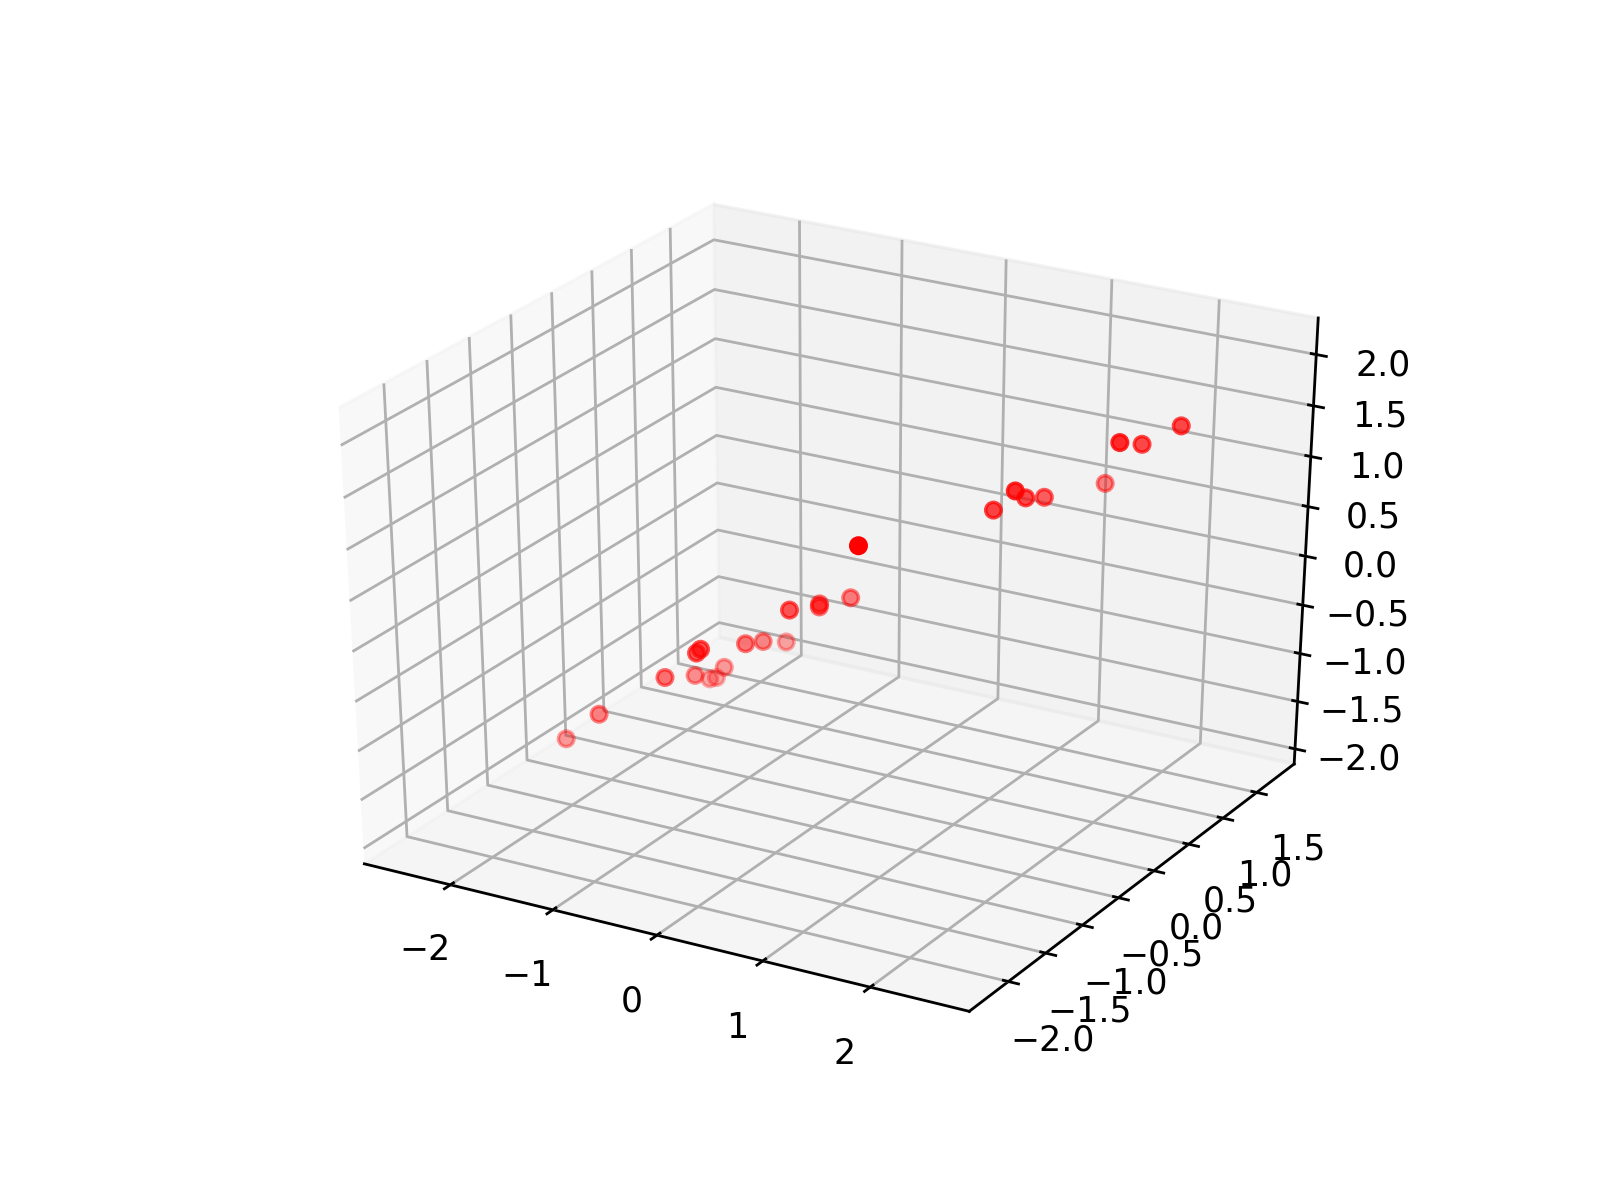

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c="r", marker="o")
plt.show()

Let's visualize the loss function in two ways. The main point of chosing such nice data was to get nice loss surfaces .

<IPython.core.display.Javascript object>


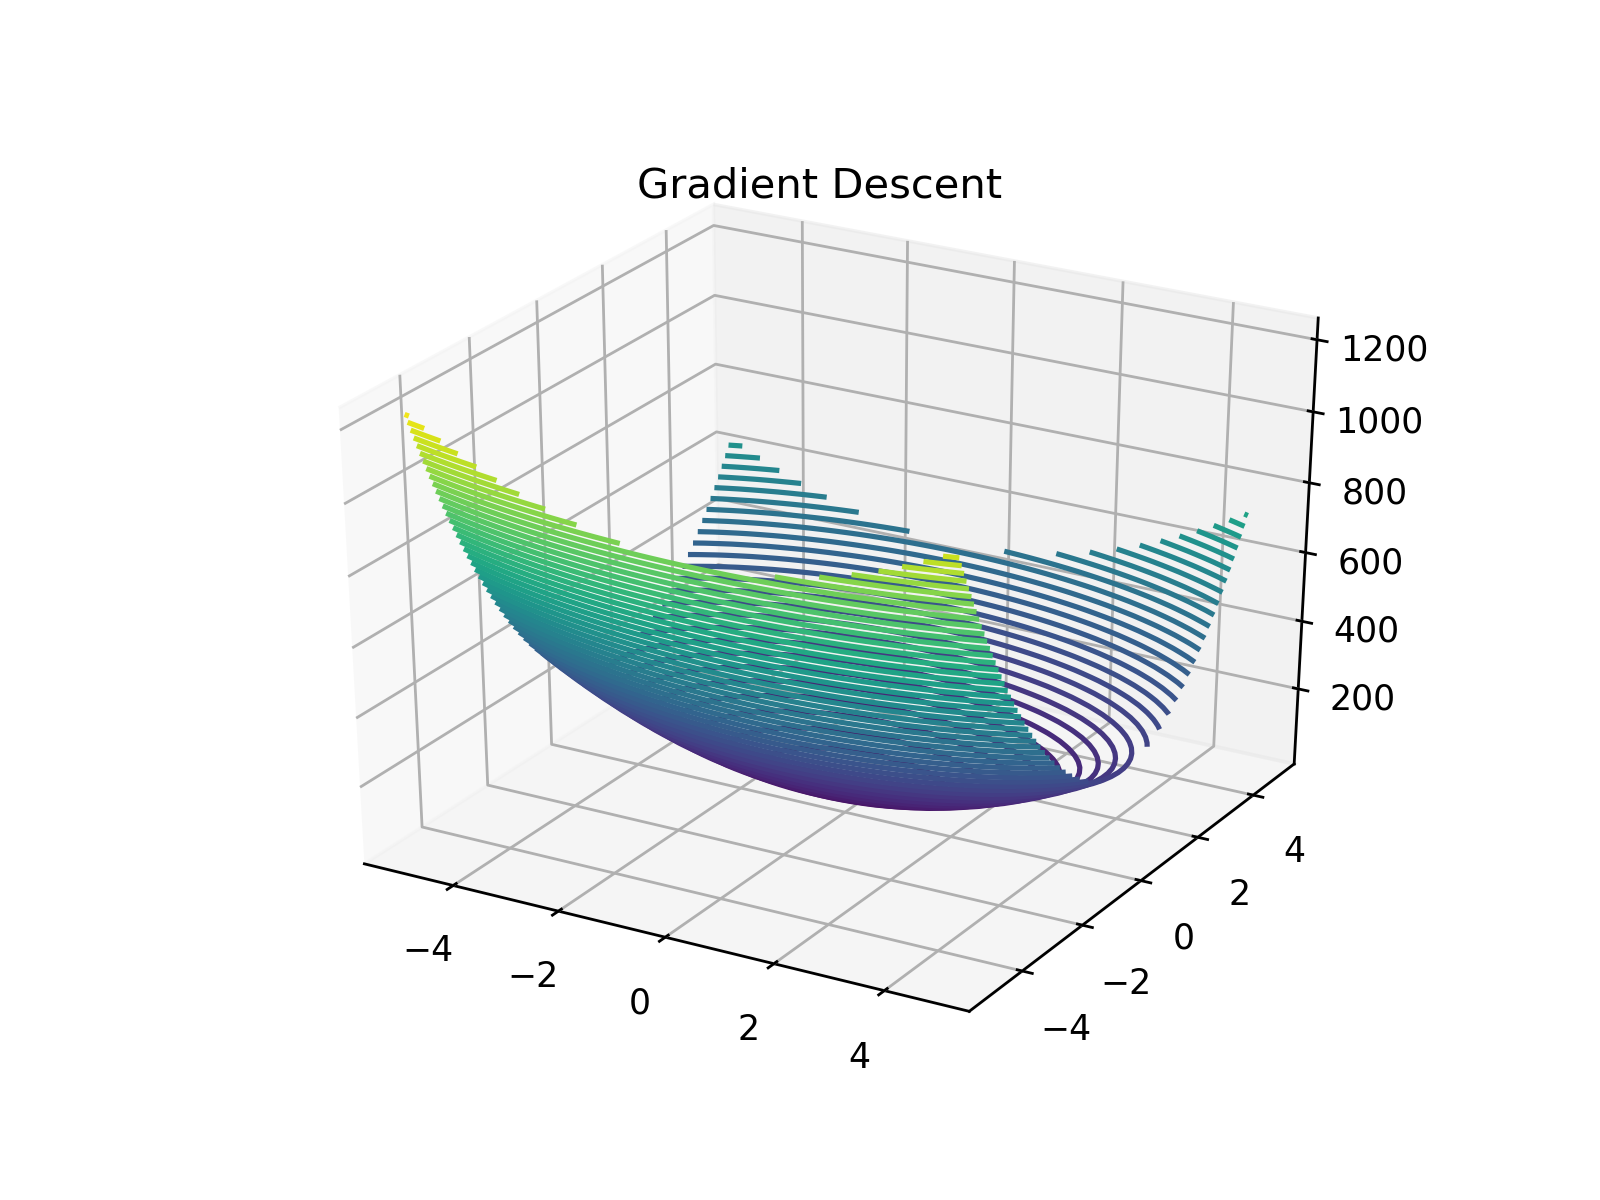

In [6]:
render_points(X,y,[],isocline=False)

<IPython.core.display.Javascript object>


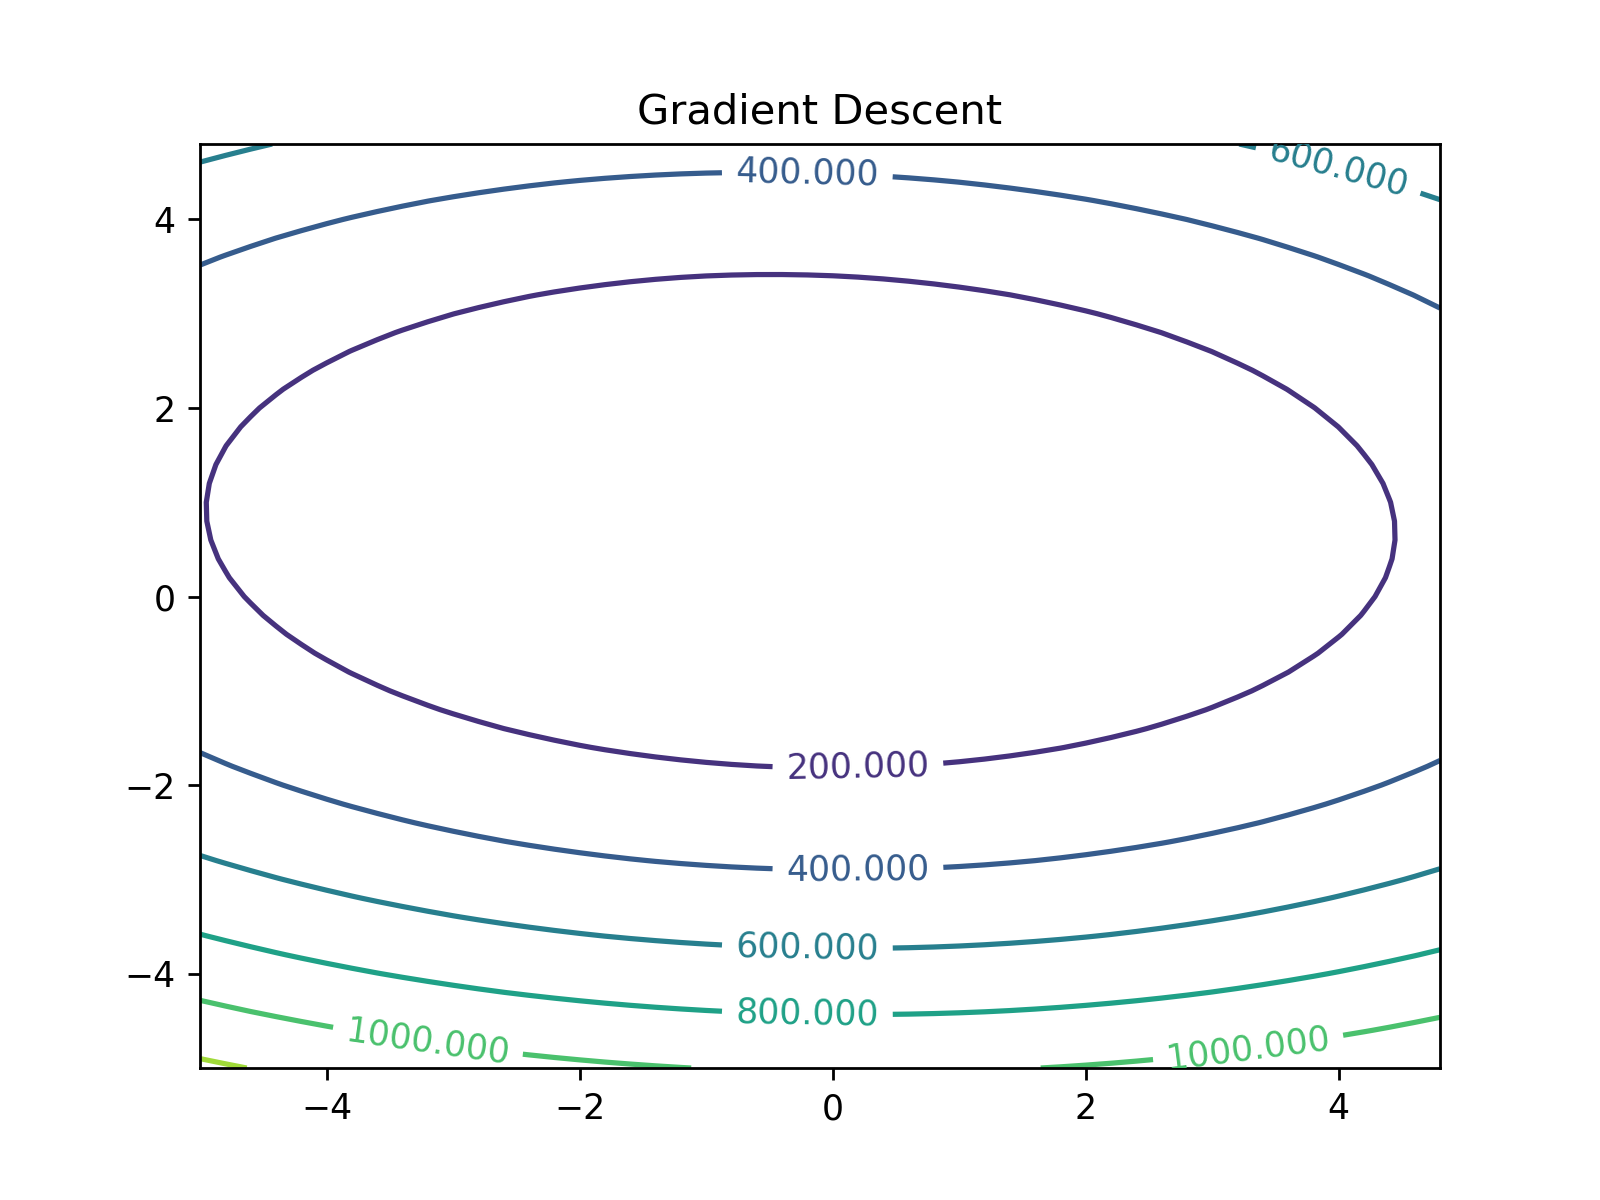

In [7]:
render_points(X,y,[],isocline=True)

Gradient Descent and Least Squares
---

Our cost function is $$J(\theta) = \frac{1}{2} \sum_{i=1}^{n} \left(x^{(i)} \theta - y^{(i)}\right)^2$$. 

* Let's compute this derivative on the board!

Iteration
--
The iteration rule is:
$$\theta \leftarrow \theta - \alpha \nabla_{\theta} J(\theta)$$

In which $\alpha$ is the stepsize.

The derivative for a single example say is $x^T(x^T\theta - y)$ writing $x=x^{(i)}$ and $y=y^{(i)}$, for reasons of nicer markdown rendering only.

<IPython.core.display.Javascript object>


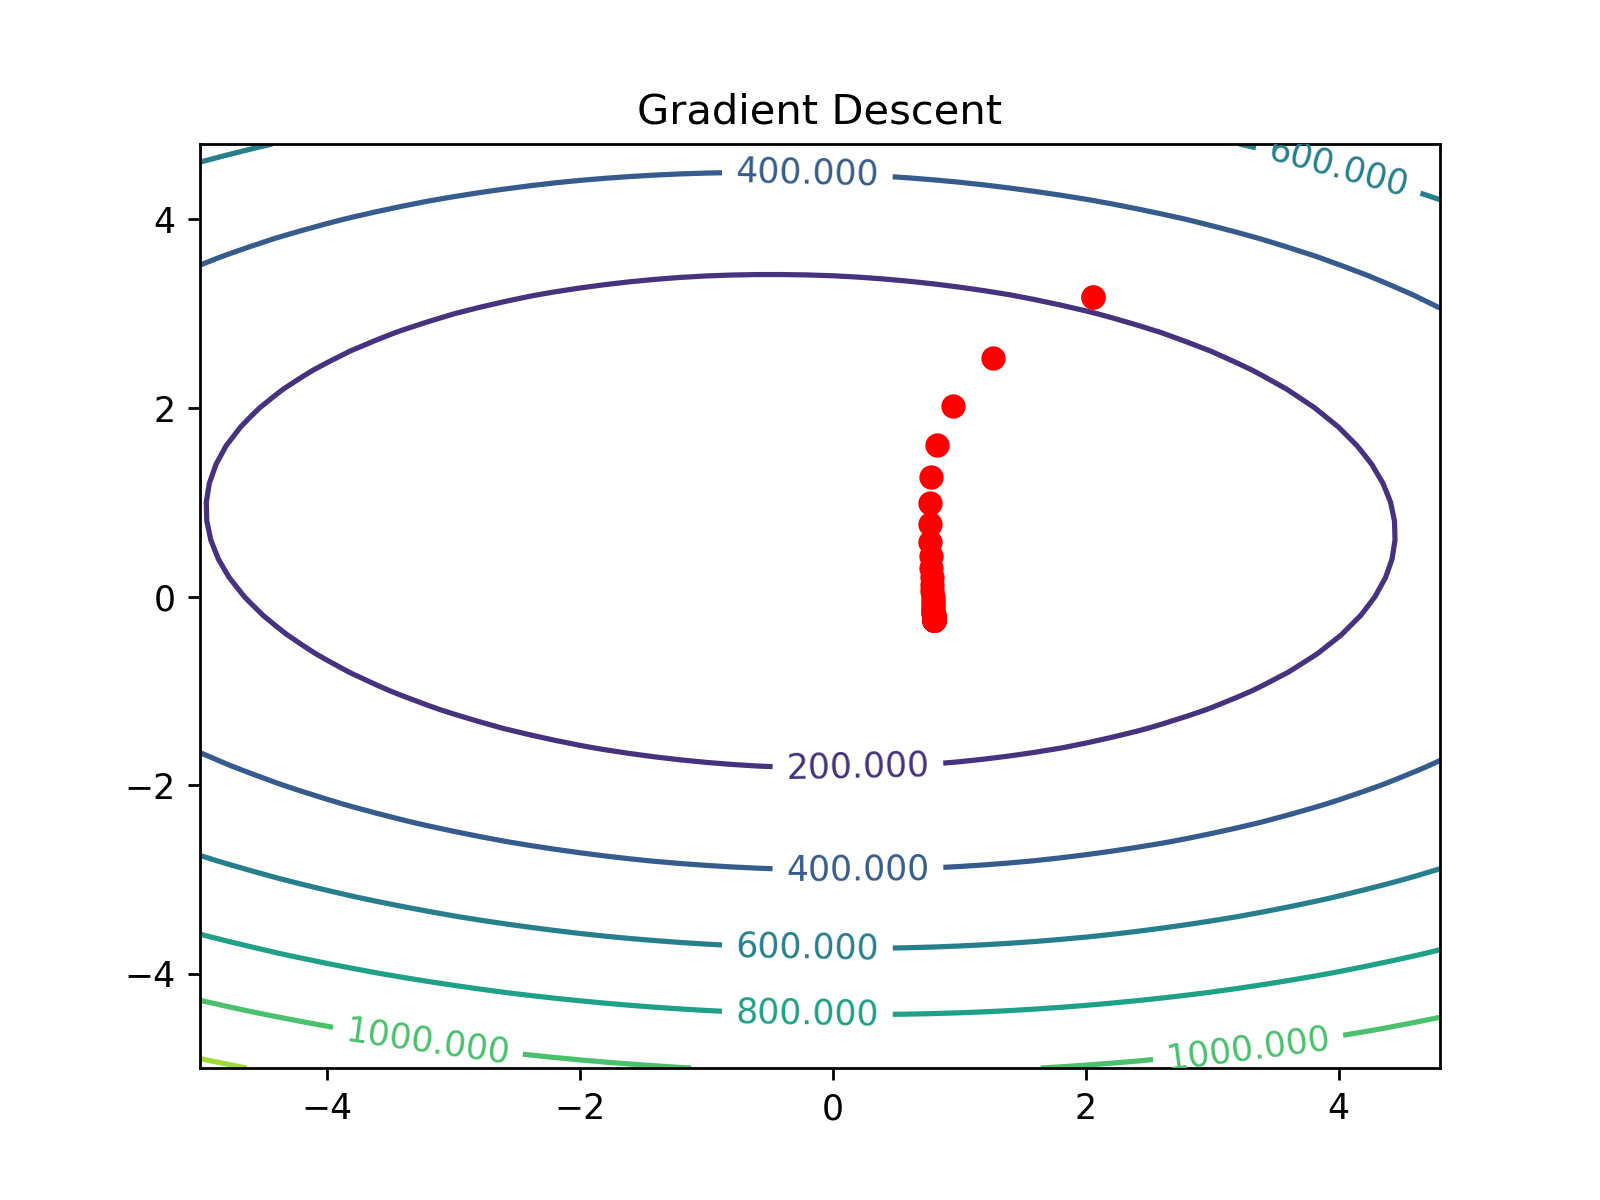

In [8]:
theta = np.matrix([4,4]).T
T = 50
alpha = 0.01
points = []
for t in range(T):
    theta = theta - alpha*X.T@(X@theta-y)
    points.append(theta)
ani = render_points(X,y,points, isocline=True)

Let's look at predictions!

That is for a data point $x$ we predict its label by $x^Ty$

<IPython.core.display.Javascript object>


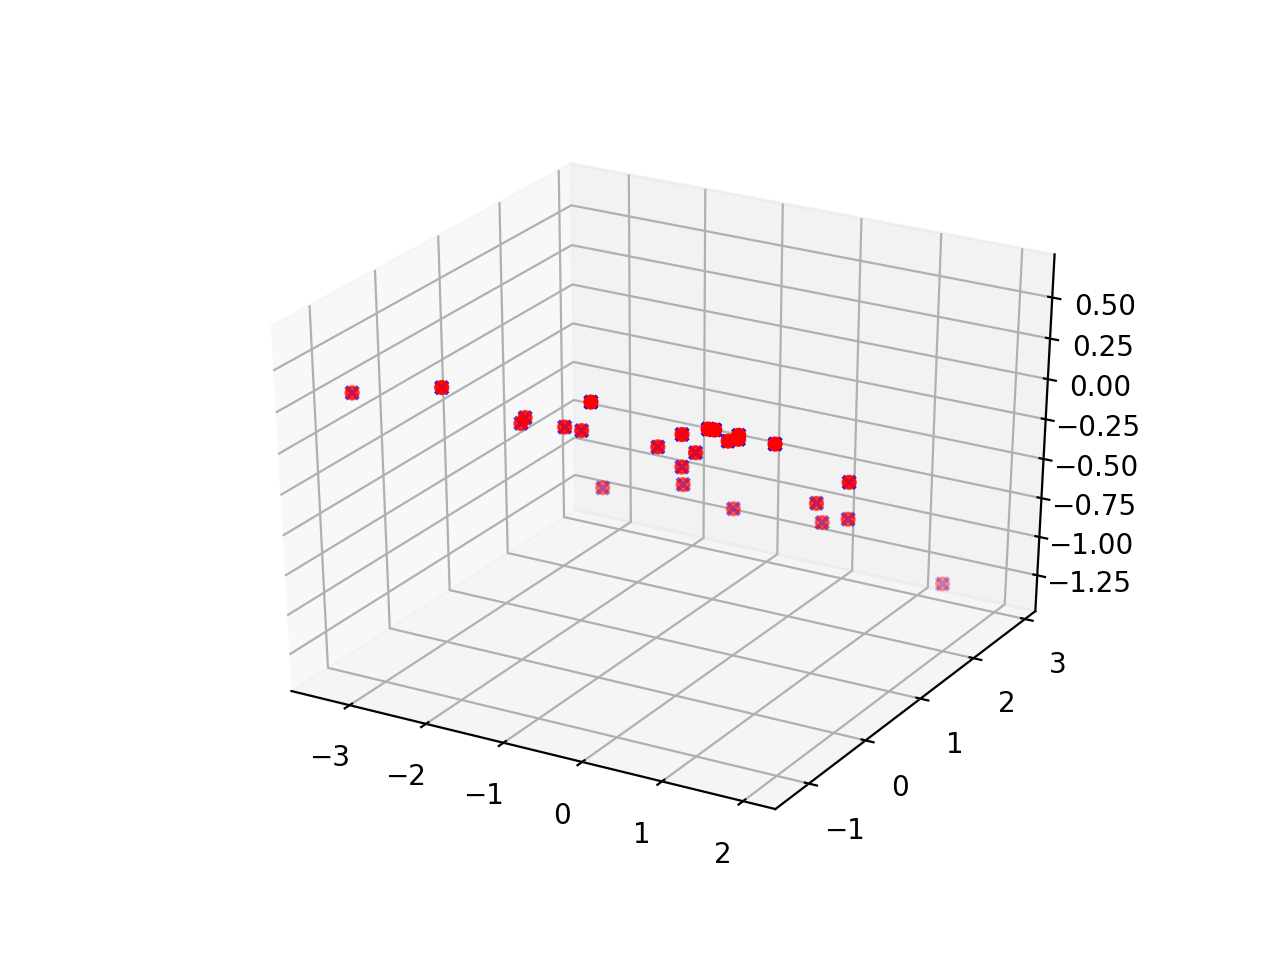

In [9]:
pred = X@theta # predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c="r", marker="o")
ax.scatter(X[:,0], X[:,1], pred, c="b", marker="x")
plt.show()

In [9]:
theta - theta_true

matrix([[-6.06160237e-05],
        [-1.74119958e-04]])

Stochastic Gradient Descent
---

Why wait to see the whole dataset? It turns out an even simpler algorithm is widely used and can be _much_ faster. 

* Intuitevly, if you're data is already noisy we can get a good answer but much faster.

* In both casees, we are going to take 50 steps. But in SGD, we'll only look at $1$ point not all $n$ points!

The update algorithm, well it's what we derived on the board to start!

<IPython.core.display.Javascript object>


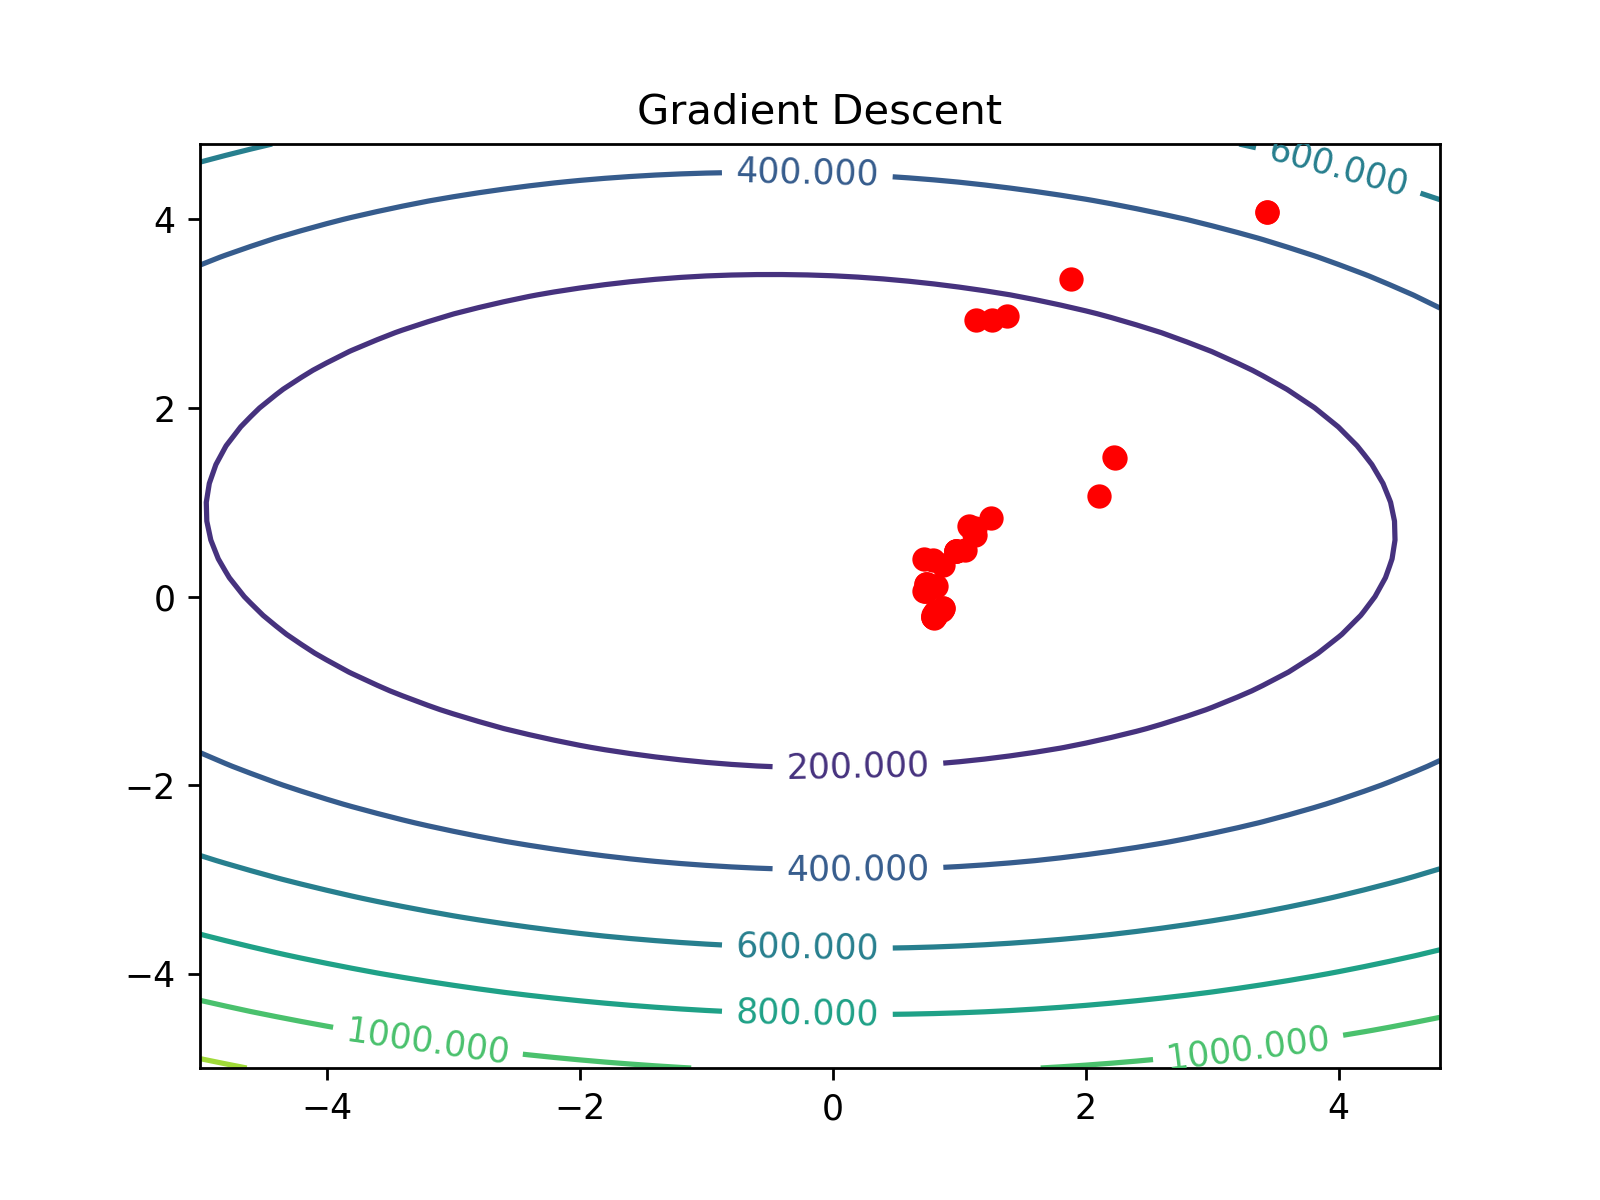

In [10]:
theta = np.matrix([4,4]).T
T = 50
# Shuffle the examples
n      = X.shape[0]
perm   = np.arange(n)
np.random.shuffle(perm)
points = []
for t in range(T):
    i = t % n
    xi,yi = X[i,:].T, y[i] 
    theta = theta - 0.1*xi*(xi.T@theta-yi)
    points.append(theta)
ani = render_points(X,y,points, isocline=True)

<IPython.core.display.Javascript object>


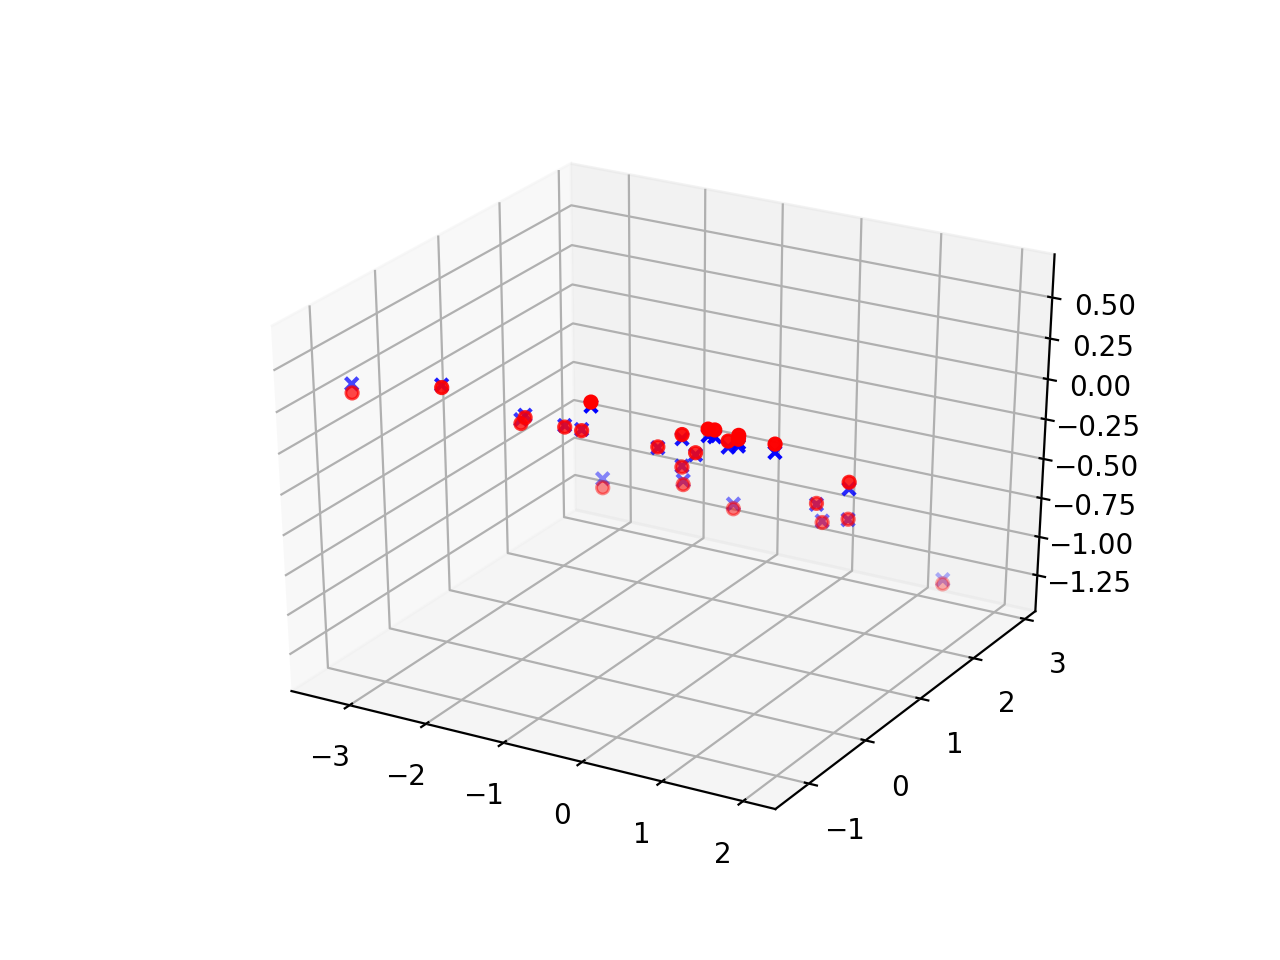

In [12]:
pred = X@theta # predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c="r", marker="o")
ax.scatter(X[:,0], X[:,1], pred, c="b", marker="x")
plt.show()

Convergence
----

Some of the most interesting models used today are not bowl shape, and they may have spurious local minima (or not! sometimes we don't know!). What does gradient descent do in this situation? It's unclear!

<IPython.core.display.Javascript object>


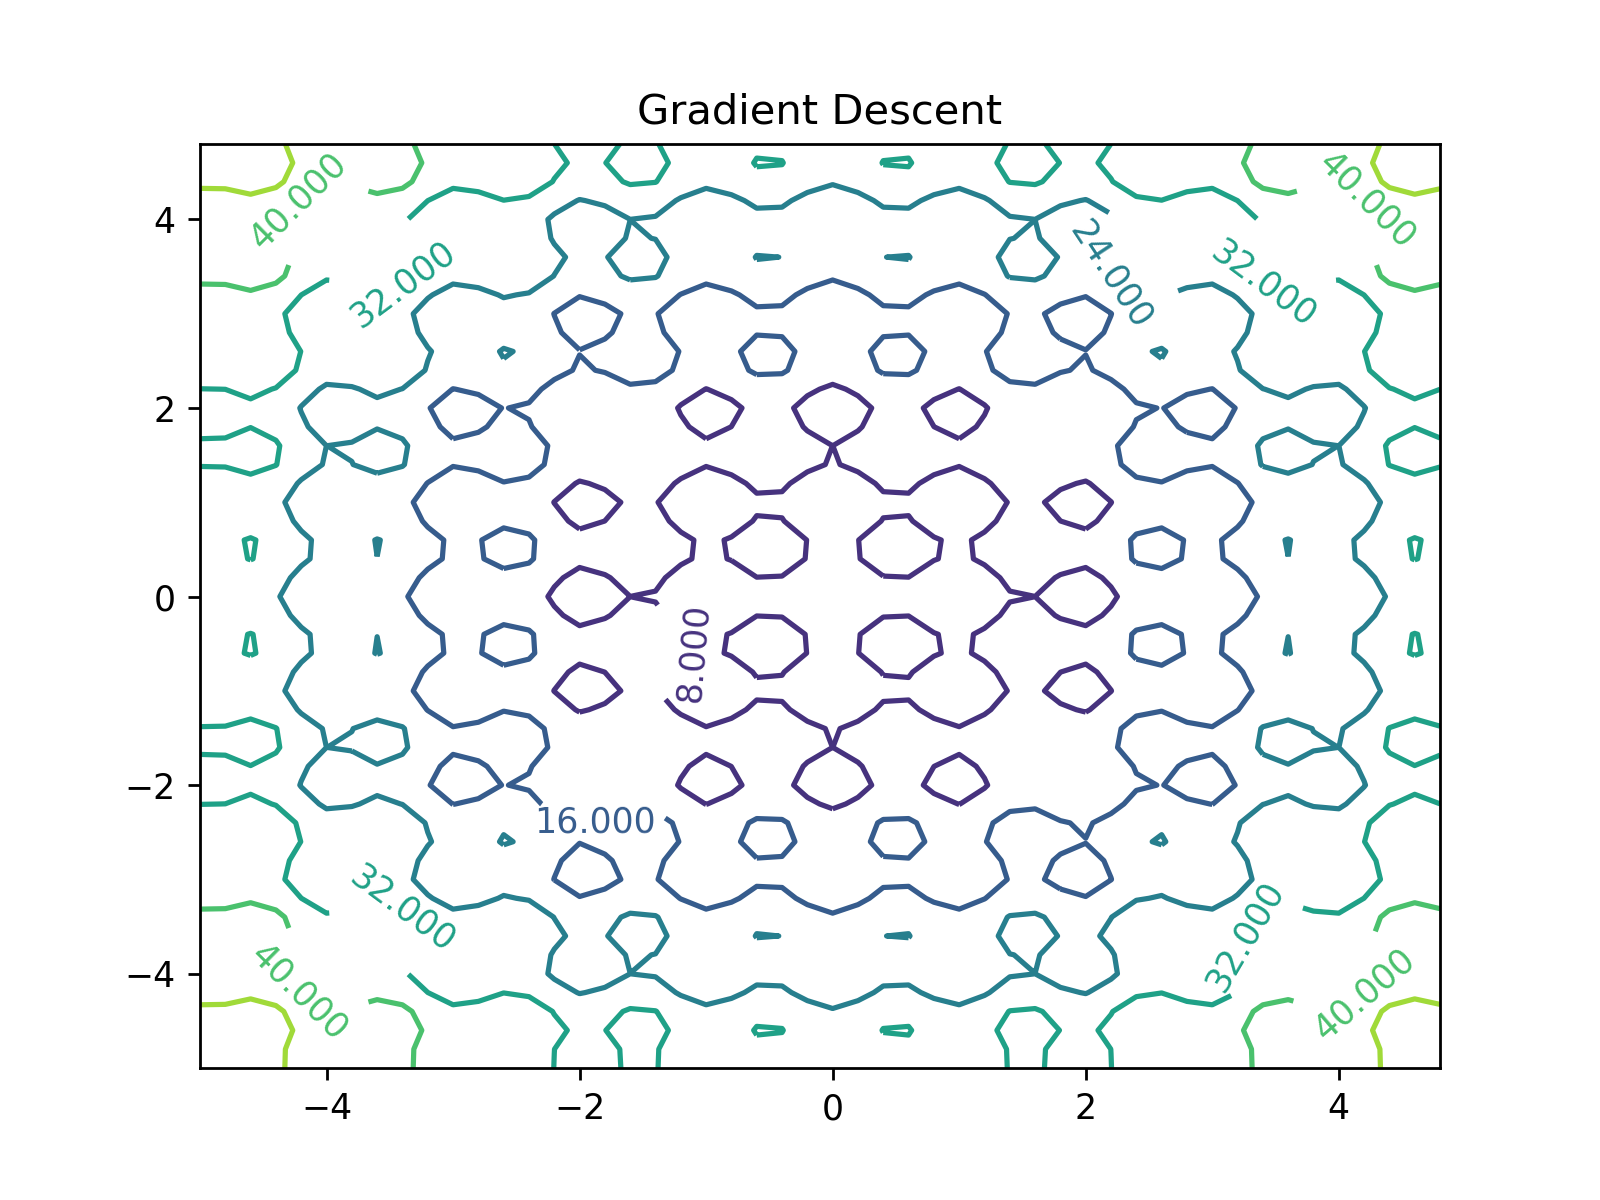

In [11]:
import math
a = 3
def nasty_loss(X, theta_1, theta_2, y, delta=0, a=3):
    points = np.zeros( (len(theta_1), len(theta_2)) )
    for i,t_1 in enumerate(theta_1):
        for j,t_2 in enumerate(theta_2):
            points[i,j] =  2*a + (t_1**2 - a*math.cos(2*math.pi*t_1) + t_2**2 - a*math.cos(2*math.pi*t_2))
    return points

ani = render_points(X,y,[], isocline=True, loss=nasty_loss)

<IPython.core.display.Javascript object>


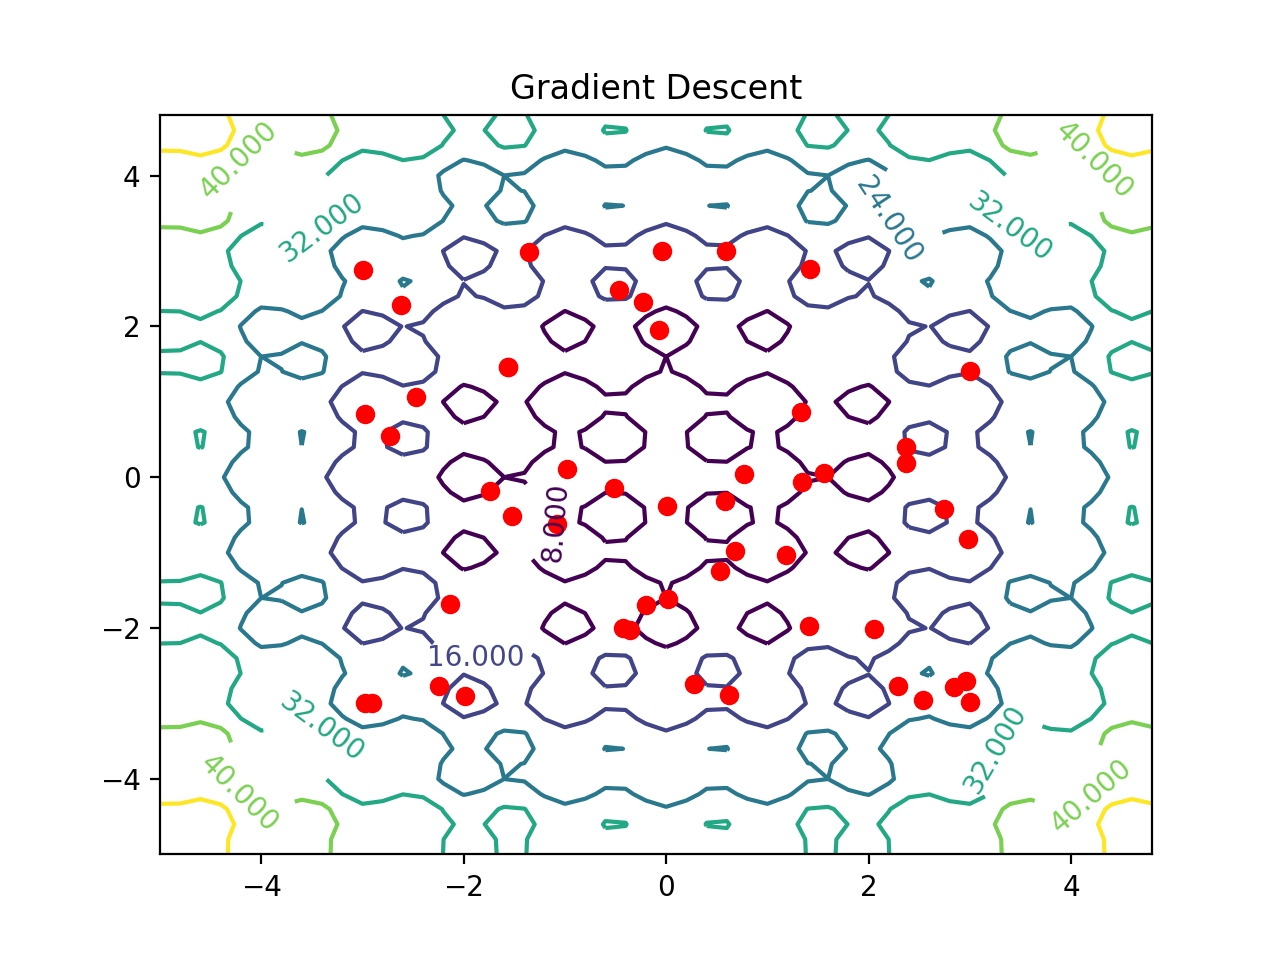

In [14]:
theta = np.matrix(np.random.randn(2,1))
T = 50
alpha = 0.01
points = []
for t in range(T):
    theta = theta - (theta + a*np.sin(2*math.pi*theta))
    points.append(theta)
ani = render_points(X,y,points, isocline=True, loss=nasty_loss)

Take-away points
---
1. SGD can be faster than batch gradient descent, intuitevely, when the dataset contains redundancy--say the same point occurs many times--SGD could complete before batch gradient does one iteration!
   * NB: This is **common** in machine learning, we need redundancy to learn!
   * This algorithm is **widely** used in practice. Fancy tools like pytorch and Tensorflow use this. (They compute the gradients for you!). Odds are you have interacted today with some system that was trained by SGD--and not in this course!

2. Convergence is not guaranteed. When bowl-shaped, we have a robust (and interesting!) theory. Many models you'll see are not convex, and one of the great mysteries right now is how some of the industrial models are highly nonconvex.

3. There are annoying parameters in machine learning. Sigh. You met your first one, the learning rate. It sadly won't be the last... You can play with the learning rate--note it's higher in SGD!.


*Aside* for the researchers and mathematics types: almost all theory suggests that you sample with replacement, but as above this shuffling approach is more widely used. Shockingly, while some [theory](http://proceedings.mlr.press/v23/recht12/recht12.pdf) suggests it's better only recently have folks been able to show that's true!



Back to the real data (if you dare!)
----

Beware, you need to scale your data to get the above code to work. A little bit of playing with it is helpful!

In [12]:
url="https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data"
d=pd.read_csv(url, header=None).values

# Construct the dataset
city_mpg, hi_mpg = np.matrix(d[:n,23], dtype=float).T,np.matrix(d[:n,24], dtype=float).T
X_car = np.concatenate([city_mpg, np.ones( (n,1))],axis=1) # add in the bias term
y_car = hi_mpg

In [13]:
theta_car = np.matrix( [1.5,1] ).T
for t in range(10000):
    theta_car = theta_car - 1e-4*X_car.T@(X_car@theta_car-y_car)
theta_car

matrix([[1.00870733],
        [5.51742967]])

In [14]:
theta_linear = np.linalg.inv(X_car.T@X_car)@X_car.T@y_car
theta_linear

matrix([[0.99620855],
        [5.85008478]])